## **Selecting data for ML Use Case 1**

In this notebook, we're delving into the RDD2022 dataset, specifically honing in on annotated images from Japan. Our mission is clear: to process annotation files, visualize annotations on images, and prep the data for further analysis, all with the aim of curating a dataset subset tailored for ML Use Case 1. Our focus? The detection of potholes (label code: D40). Through meticulous exploration, analysis, and evaluation, we're striving to handpick a dataset subset that not only meets but exceeds the requirements of ML Use Case 1, fueling the development of cutting-edge machine learning models for pothole detection.

In [1]:
# Import necessary libraries
import glob
import os
import pandas as pd
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

### **1. Set Up Data Paths and Load Data:**


In [2]:
# 1. Set up paths and load data
data_root_dir = "../../project/data/RDD2022_released_through_CRDDC2022/RDD2022/"
nationality = "Japan"
mode = "Train"

In [3]:
image_destination_path = os.path.join(data_root_dir, nationality, nationality, mode, "images")
annot_destination_path = os.path.join(data_root_dir, nationality, nationality, mode, "annotations/xmls") 

# Ensure paths exist
assert os.path.exists(image_destination_path), print("Image path not found")
assert os.path.exists(annot_destination_path), print("Annotation path not found")

In [4]:
# Get list of image and annotation files
image_list = glob.glob(image_destination_path+"/*.jpg")
annot_list = glob.glob(annot_destination_path+"/*.xml")

### **2. Define Label Mapping:**

In [5]:
# 2. Define label map
label_map = {
    "D00": "Wheel mark part",
    "D01": "Construction joint part",
    "D10": "Equal interval",
    "D11": "Construction joint part",
    "D20": "Partial pavement",
    "D40": "Rutting, bump, pothole, separation",
    "D43": "Crosswalk blur",
    "D44": "White line blur"
}

### **3. Read, Parse and Visualize Annotations::**

In [6]:
# 3. Define functions for reading and parsing XML, and drawing bounding boxes
def read_and_parse_xml(xml_file_path):
    """Reads and parses an XML file."""
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    return root

# Function to draw bounding boxes on the image
def draw_bounding_boxes(image_path, annotations):
    """Draws bounding boxes on the image."""
    image = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if image is None:
        print(f"Error loading image {image_path}")
        return

    for obj in annotations.findall('object'):
        name = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        # Draw the bounding box on the image
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(image, name, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Convert BGR to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

In [7]:
# Path to the XML file
xml_file_path = annot_list[10]

# Path to the image file
image_file_path = image_list[10]

print(xml_file_path)
print(image_file_path)

# Read and parse the XML file
annotations = read_and_parse_xml(xml_file_path)

../../project/data/RDD2022_released_through_CRDDC2022/RDD2022/Japan\Japan\Train\annotations/xmls\Japan_000011.xml
../../project/data/RDD2022_released_through_CRDDC2022/RDD2022/Japan\Japan\Train\images\Japan_000011.jpg


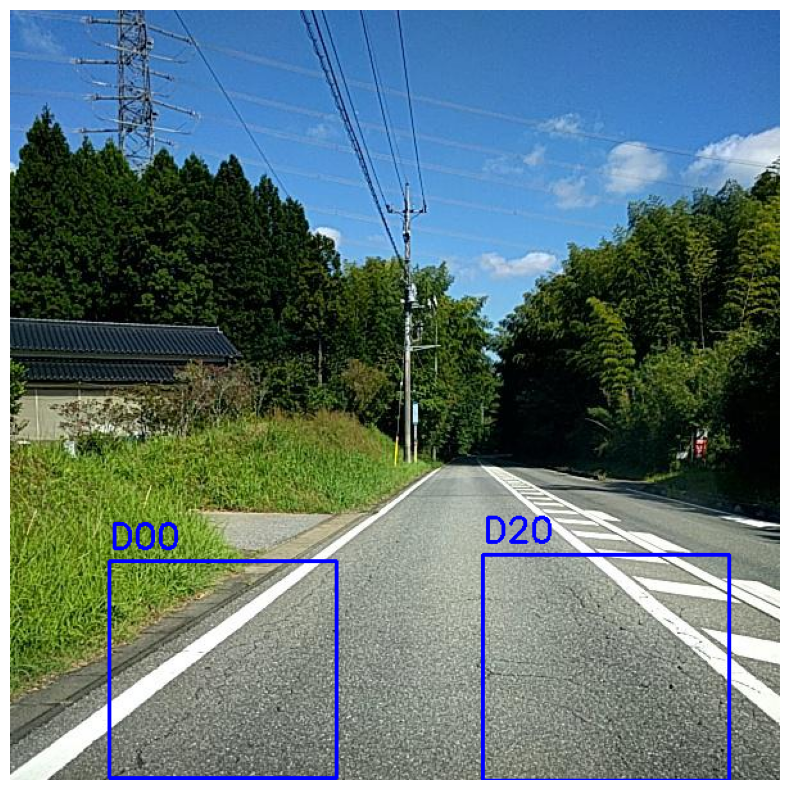

In [8]:
# Draw bounding boxes on the image
draw_bounding_boxes(image_file_path, annotations)

### **4. Process Annotations in Parallel:**

In [9]:
# 4. Functions for filtering annotations and parallel processing

def encoded_obj_annotations(annotations):
    """Encodes object annotations."""
    objects_names = []
    for obj in annotations.findall('object'):
        label_code = obj.find('name').text
        objects_names.append(label_code)
    return objects_names

def process_annotation_file(xml_file_path):
    """Processes a single annotation file."""
    annotations = read_and_parse_xml(xml_file_path)
    objects_names = encoded_obj_annotations(annotations)
    return xml_file_path, objects_names

# Function to process all annotation files in parallel and show progress
def process_all_annotations(xml_files):
    """Processes all annotation files in parallel and shows progress."""
    results = []
    with ThreadPoolExecutor() as executor:
        future_to_xml = {executor.submit(process_annotation_file, xml_file): xml_file for xml_file in xml_files}
        for future in tqdm(as_completed(future_to_xml), total=len(future_to_xml), desc="Processing files"):
            xml_file = future_to_xml[future]
            try:
                xml_file_path, objects_names = future.result()
                results.append((xml_file_path, objects_names))
            except Exception as exc:
                print(f"{xml_file} generated an exception: {exc}")
    return results

In [10]:
annotations = read_and_parse_xml(annot_list[0])
encoded_obj_annotations(annotations)

['D20', 'D40', 'D10', 'D00']

In [11]:
# Process all annotations
results = process_all_annotations(annot_list)

Processing files: 100%|██████████| 10506/10506 [00:01<00:00, 7700.69it/s]


### **6. Create a DataFrame with Encoded Categories:**

In [12]:
# df = pd.DataFrame(results, columns=['xml_file_path', 'objects'])

# Convert the data to a DataFrame
df = pd.DataFrame(results, columns=['xml_file_path', 'objects'])

# Create columns for each label with binary encoding
for label in label_map.keys():
    df[label] = df['objects'].apply(lambda x: x.count(label))

In [13]:
df

,xml_file_path,objects,D00,D01,D10,D11,D20,D40,D43,D44
0,../../project/data/RDD2022_released_through_CR...,"[D50, D50, D50, D10, D00, D50]",1,0,1,0,0,0,0,0
1,../../project/data/RDD2022_released_through_CR...,"[D50, D10]",0,0,1,0,0,0,0,0
2,../../project/data/RDD2022_released_through_CR...,[D20],0,0,0,0,1,0,0,0
3,../../project/data/RDD2022_released_through_CR...,"[D44, D50]",0,0,0,0,0,0,0,1
4,../../project/data/RDD2022_released_through_CR...,[D20],0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
10501,../../project/data/RDD2022_released_through_CR...,"[D40, D40]",0,0,0,0,0,2,0,0
10502,../../project/data/RDD2022_released_through_CR...,"[D44, D10, D10]",0,0,2,0,0,0,0,1
10503,../../project/data/RDD2022_released_through_CR...,[D00],1,0,0,0,0,0,0,0
10504,../../project/data/RDD2022_released_through_CR...,"[D44, D44, D50]",0,0,0,0,0,0,0,2


### **7. Selecting D40 samples**

In [14]:
include_labels = {"D40"}

In [15]:
df[df["objects"].apply(lambda x: True if include_labels.intersection(set(x)) else False)]

,xml_file_path,objects,D00,D01,D10,D11,D20,D40,D43,D44
20,../../project/data/RDD2022_released_through_CR...,"[D20, D40, D40]",0,0,0,0,1,2,0,0
30,../../project/data/RDD2022_released_through_CR...,"[D40, D40, D40]",0,0,0,0,0,3,0,0
41,../../project/data/RDD2022_released_through_CR...,[D40],0,0,0,0,0,1,0,0
69,../../project/data/RDD2022_released_through_CR...,"[D40, D40, D40, D40, D40, D40, D20, D50]",0,0,0,0,1,6,0,0
72,../../project/data/RDD2022_released_through_CR...,"[D40, D40]",0,0,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...
10479,../../project/data/RDD2022_released_through_CR...,"[D40, D40, D40]",0,0,0,0,0,3,0,0
10482,../../project/data/RDD2022_released_through_CR...,"[D40, D50]",0,0,0,0,0,1,0,0
10484,../../project/data/RDD2022_released_through_CR...,"[D20, D40, D20, D20]",0,0,0,0,3,1,0,0
10490,../../project/data/RDD2022_released_through_CR...,"[D20, D40]",0,0,0,0,1,1,0,0
